# Reproducing primer on reproducibility

Getting python code in [Arribas-Bel _et al._ (2017)](http://doi.org/10.1007/978-3-319-50590-9_17) working in 2021. 

> Arribas-Bel, D., de Graaff, T. and Rey, S.J. (2017). Looking at John Snow’s Cholera map from the twenty first century: A practical primer on reproducibility and open science. _In_: Jackson, R and Schaeffer, P. (Eds.) _Regional Research Frontiers Vol. 2_ (pp. 283-306). Springer, Cham. doi: 10.1007/978-3-319-50590-9_17

In [12]:
import seaborn as sns
import pandas as pd
import libpysal as lps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### Loading and exploring the data

In [2]:
# Load point data
pumps = gpd.read_file('../../data/dani/Pumps.shp')
# Load building blocks
blocks = gpd.read_file('../../data/dani/polys.shp')
# Load street network
js = gpd.read_file('../../data/dani/streets_js.shp')

In [3]:
#Check data structure
js.head()

,Deaths,seg_len,segIdStr,Deaths_dens,geometry
0,0.0,6.403124,s0-1,0.000000,"LINESTRING (529521.000 180866.000, 529516.000 ..."
1,1.0,92.773279,s0-2,1.077897,"LINESTRING (529521.000 180866.000, 529592.980 ..."
2,0.0,38.418745,s0-3,0.000000,"LINESTRING (529521.000 180866.000, 529545.000 ..."
3,0.0,39.623226,s1-25,0.000000,"LINESTRING (529516.000 180862.000, 529487.000 ..."
4,26.0,143.808901,s1-27,18.079549,"LINESTRING (529516.000 180862.000, 529431.000 ..."


<AxesSubplot:>

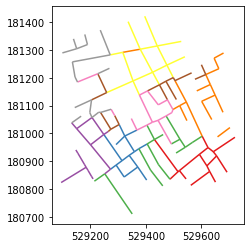

In [4]:
# Quickly plot the streets
js.plot(cmap='Set1')

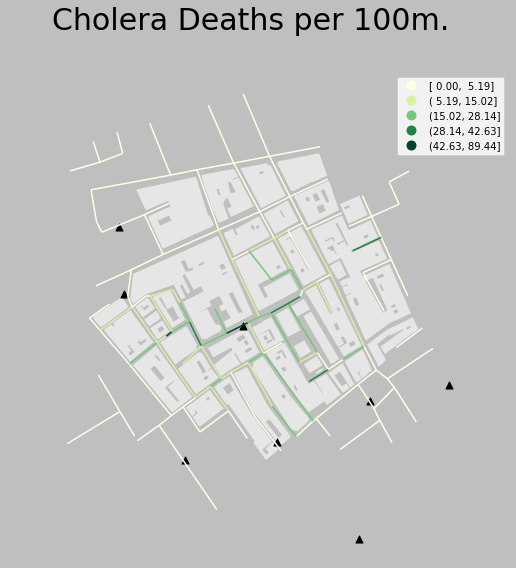

In [5]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)

# Quantile choropleth of deaths at the street level
js.plot(column='Deaths_dens', scheme='fisher_jenks', ax=ax, cmap='YlGn', legend=True)

# Plot pumps
xys = np.array([(pt.x, pt.y) for pt in pumps.geometry])
ax.scatter(xys[:, 0], xys[:, 1], marker='^', color='k', s=50)

# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.75')
# Keep axes proportionate
plt.axis('equal')
# Title
f.suptitle('Cholera Deaths per 100m.', size=30)
# Draw
plt.show()

In [6]:
import spaghetti as sp

In [7]:
#Load the network
ntw = sp.Network('../../data/dani/streets_js.shp')

/home/james/anaconda3/envs/john-snow/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There is 1 island with id: (73, 74).
  warnings.warn(message)


In [8]:
# Create the spatial weights matrix
w = ntw.contiguityweights(graph=False)
# Rename IDs to match those in the `segIdStr` column
w.remap_ids(js['segIdStr'])
# Row standardize the matrix
w.transform = 'R'

('WARNING: ', 's70-90', ' is an island (no neighbors)')


In [9]:
w['s0-1']

{'s0-2': 0.25, 's0-3': 0.25, 's1-25': 0.25, 's1-27': 0.25}

## Spatial Lag

In [16]:
js['w_Deaths_dens'] = lps.weights.lag_spatial(w, js['Deaths_dens'])

In [17]:
js[['segIdStr', 'Deaths_dens', 'w_Deaths_dens']].head()

,segIdStr,Deaths_dens,w_Deaths_dens
0,s0-1,0.000000,4.789361
1,s0-2,1.077897,0.000000
2,s0-3,0.000000,0.538948
3,s1-25,0.000000,6.026516
4,s1-27,18.079549,0.000000


In [21]:
w.neighbors['s0-1']

['s0-2', 's0-3', 's1-25', 's1-27']

In [18]:
# Note that we first index the table on the index variable
neigh = js.set_index('segIdStr').loc[w.neighbors['s0-1'], 'Deaths_dens']
neigh

segIdStr
s0-2      1.077897
s0-3      0.000000
s1-25     0.000000
s1-27    18.079549
Name: Deaths_dens, dtype: float64

In [22]:
neigh.mean()

4.789361269659251

In [23]:
js['Deaths_dens_std'] = (js['Deaths_dens'] - js['Deaths_dens'].mean()) / js['Deaths_dens'].std()

In [24]:
js['w_Deaths_dens_std'] = lps.weights.lag_spatial(w, js['Deaths_dens_std'])

In [26]:
js[['segIdStr', 'Deaths_dens', 'w_Deaths_dens','w_Deaths_dens_std']].head()

,segIdStr,Deaths_dens,w_Deaths_dens,w_Deaths_dens_std
0,s0-1,0.000000,4.789361,-0.190281
1,s0-2,1.077897,0.000000,-0.556528
2,s0-3,0.000000,0.538948,-0.515314
3,s1-25,0.000000,6.026516,-0.095675
4,s1-27,18.079549,0.000000,-0.556528
